In [1]:
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [4]:
!unzip /content/drive/MyDrive/lung_image_sets.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_image_sets/lung_aca/lungaca1906.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1907.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1908.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1909.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca191.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1910.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1911.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1912.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1913.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1914.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1915.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1916.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1917.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1918.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca1919.jpeg  
  inflating: lung_image_sets/lung_aca/lungaca192.jpeg  
  inflating: lung_image_sets/lung_aca/l

In [5]:
path = '/content/lung_image_sets'
classes = os.listdir(path)
classes

['lung_scc', 'lung_n', 'lung_aca']

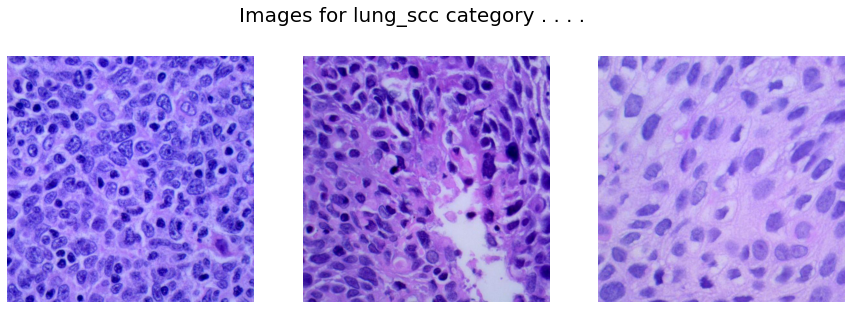

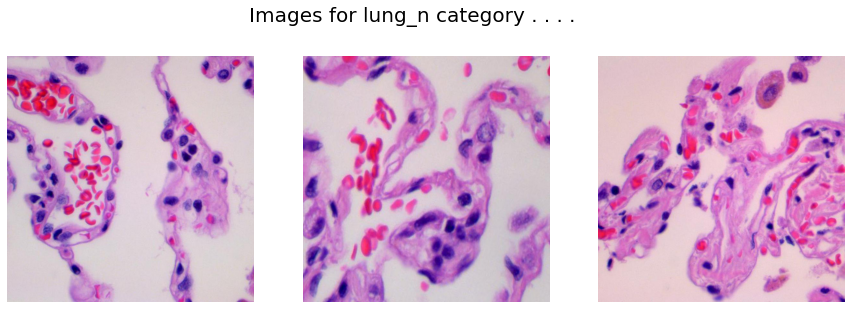

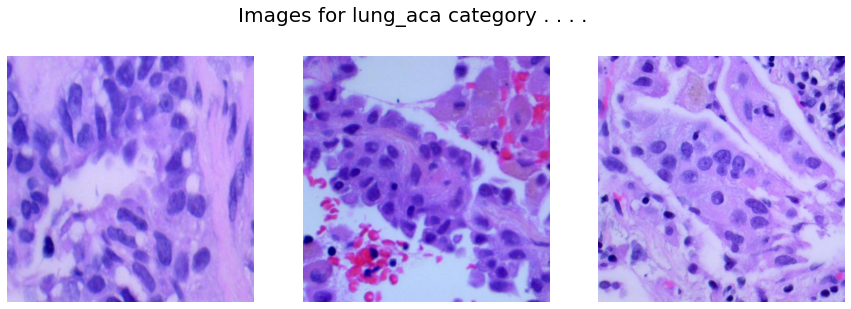

In [6]:
path = 'lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [7]:
IMG_SIZE = 128
SPLIT = 0.3
EPOCHS = 200
BATCH_SIZE = 16

In [8]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(4204, 128, 128, 3) (1802, 128, 128, 3)


In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 16, 16, 128)    

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/200
  4/263 [..............................] - ETA: 4s - loss: 0.8484 - accuracy: 0.6406  

263/263 [==============================] - 6s 17ms/step - loss: 0.5090 - accuracy: 0.7919 - val_loss: 8.3360 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 2/200
263/263 [==============================] - 4s 16ms/step - loss: 0.3679 - accuracy: 0.8525 - val_loss: 1.3356 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 3/200
263/263 [==============================] - 4s 16ms/step - loss: 0.3463 - accuracy: 0.8649 - val_loss: 3.0063 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 4/200
263/263 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8442
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
263/263 [==============================] - 4s 16ms/step - loss: 0.3985 - accuracy: 0.8442 - val_loss: 53.8649 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 5/200
263/263 [==============================] - 4s 16ms/step - loss: 0.4364 - accuracy: 0.8147 - val_loss: 4.4909 - val_accuracy: 0.3319 - lr: 5.0000e-04
Epoch 6/200
263/263 [==============================] - 4s 16m

In [ ]:

Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

57/57 [==============================] - 1s 8ms/step


In [ ]:

metrics.confusion_matrix(Y_val, Y_pred)

array([[519,  52,  33],
       [ 48, 531,  12],
       [  6,   0, 601]])

In [ ]:

print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.91      0.86      0.88       604
    lung_scc       0.91      0.90      0.90       591
      lung_n       0.93      0.99      0.96       607

    accuracy                           0.92      1802
   macro avg       0.92      0.92      0.92      1802
weighted avg       0.92      0.92      0.92      1802

